In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
import datetime 

interventions_df = pd.read_csv('data/donneesouvertes-interventions-sim.csv')
interventions_df['CREATION_DATE_TIME'] = interventions_df['CREATION_DATE_TIME'].astype('datetime64[ns]')  
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895


In [3]:
interventions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538766 entries, 0 to 538765
Data columns (total 14 columns):
INCIDENT_NBR          538766 non-null int64
CREATION_DATE_TIME    538766 non-null datetime64[ns]
INCIDENT_TYPE_DESC    538766 non-null object
DESCRIPTION_GROUPE    538760 non-null object
CASERNE               538766 non-null int64
NOM_VILLE             538766 non-null object
NOM_ARROND            538766 non-null object
DIVISION              538766 non-null int64
NOMBRE_UNITES         538633 non-null float64
CIV                   479899 non-null float64
MTM8_X                538766 non-null float64
MTM8_Y                538766 non-null float64
LONGITUDE             538766 non-null float64
LATITUDE              538766 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3), object(4)
memory usage: 57.5+ MB


In [4]:
interventions_df['NOM_ARROND'] = np.where(interventions_df['NOM_ARROND'] == 'Indéterminé', interventions_df['NOM_VILLE'], interventions_df['NOM_ARROND']) 
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895


In [5]:
fire_types = [
'10-22 avec feu',
'Feu de champ *',
'Ac.vic. feu train/m√©tro F7/DES',
'Acc. sans vict. av. feu - ext.',
'Acc. sans vict. av. feu-tunnel',
'Acc. s-vict. av. feu - pont',
'Acc. s-vict. av. feu - v.r.',
'Acc. s-vict. av. feu-b√¢timent',
'Acc. s-vict. feu - train/m√©tro',
'Acc. vict. feu - tunnel F7/MOU',
'Acc. victime feu - b√¢timent',
'Acc. victime feu - pont',
'Acc. victime feu - voie rapide',
'Acc. victime feu ext.',
'D√©chets en feu',
'Feu / 2e Alerte',
'Feu / 3e Alerte',
'Feu / 4e Alerte',
'Feu / 5e Alerte',
'Feu / Agravation possible',
'Feu d\'auto (voie rapide)',
'Feu de b√¢timent',
'Feu de chemin√©e *',
'Feu de cuisson',
'Feu de nature √©lectrique',
'Feu de navire/b√¢teau',
'Feu de v√©hicule ext√©rieur',
'Feu de v√©hicule int√©rieur',
'Feu de v√©hicule sur pont',
'feu de v√©hicule tunnel F7/MOU',
'Feu v√©h. convoi (train/m√©tro)',
'M√©tro b√¢timent /10-22 avec feu',
'M√©tro b√¢timent /10-22 sans feu',
'Senteur de feu √† l\'ext√©rieur]']

interventions_df['IS_FIRE'] = interventions_df['INCIDENT_TYPE_DESC'].isin(fire_types)

In [6]:
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,IS_FIRE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786,False
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442,False
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784,False
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197,False
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895,False


In [7]:
interventions_df['Day'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).day
interventions_df['Month'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).month
interventions_df['Time1'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).time
interventions_df['Time2'] = '1970-01-01T' + interventions_df['Time1'].map(str)
interventions_df['Time3'] = interventions_df['Time2'].apply(lambda x: np.datetime64(x))
interventions_df['Time4'] = (interventions_df['Time3'] - np.datetime64('1970-01-01 00:00:00')).apply(lambda x: x.total_seconds())
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,...,MTM8_Y,LONGITUDE,LATITUDE,IS_FIRE,Day,Month,Time1,Time2,Time3,Time4
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,...,5035433.1,-73.596117,45.458786,False,3,1,20:56:02,1970-01-01T20:56:02,1970-01-01 20:56:02,75362.0
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,...,5049284.2,-73.572020,45.583442,False,3,1,21:03:52,1970-01-01T21:03:52,1970-01-01 21:03:52,75832.0
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,...,5046768.2,-73.596589,45.560784,False,3,1,21:07:00,1970-01-01T21:07:00,1970-01-01 21:07:00,76020.0
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,...,5044817.2,-73.628847,45.543197,False,3,1,21:41:46,1970-01-01T21:41:46,1970-01-01 21:41:46,78106.0
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,...,5042556.1,-73.580573,45.522895,False,3,1,21:43:32,1970-01-01T21:43:32,1970-01-01 21:43:32,78212.0


In [8]:
bins = [0, 10800, 21600, 32400, 43200, 54000, 64800,75600.0, 86400.0]
interventions_df['TIME_BUCKET'] = np.searchsorted(bins, interventions_df['Time4'].values)
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,...,LONGITUDE,LATITUDE,IS_FIRE,Day,Month,Time1,Time2,Time3,Time4,TIME_BUCKET
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,...,-73.596117,45.458786,False,3,1,20:56:02,1970-01-01T20:56:02,1970-01-01 20:56:02,75362.0,7
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,...,-73.572020,45.583442,False,3,1,21:03:52,1970-01-01T21:03:52,1970-01-01 21:03:52,75832.0,8
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,...,-73.596589,45.560784,False,3,1,21:07:00,1970-01-01T21:07:00,1970-01-01 21:07:00,76020.0,8
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,...,-73.628847,45.543197,False,3,1,21:41:46,1970-01-01T21:41:46,1970-01-01 21:41:46,78106.0,8
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,...,-73.580573,45.522895,False,3,1,21:43:32,1970-01-01T21:43:32,1970-01-01 21:43:32,78212.0,8


In [9]:
data_train = interventions_df[['Month', 'Day','NOM_ARROND',  'TIME_BUCKET','IS_FIRE']]
data_train.head()

,Month,Day,NOM_ARROND,TIME_BUCKET,IS_FIRE
0,1,3,Sud-Ouest,7,False
1,1,3,Saint-Léonard,8,False
2,1,3,Villeray / St-Michel / Parc Extension,8,False
3,1,3,Villeray / St-Michel / Parc Extension,8,False
4,1,3,Plateau Mont-Royal,8,False


In [10]:
data_train = pd.DataFrame({'count' : data_train.groupby( ['Month','Day', 'NOM_ARROND','TIME_BUCKET','IS_FIRE'] ).size()}).reset_index()
data_train.head()

,Month,Day,NOM_ARROND,TIME_BUCKET,IS_FIRE,count
0,1,1,Ahuntsic / Cartierville,1,False,13
1,1,1,Ahuntsic / Cartierville,2,False,11
2,1,1,Ahuntsic / Cartierville,2,True,1
3,1,1,Ahuntsic / Cartierville,3,False,11
4,1,1,Ahuntsic / Cartierville,4,False,16


In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84160 entries, 0 to 84159
Data columns (total 6 columns):
Month          84160 non-null int64
Day            84160 non-null int64
NOM_ARROND     84160 non-null object
TIME_BUCKET    84160 non-null int64
IS_FIRE        84160 non-null bool
count          84160 non-null int64
dtypes: bool(1), int64(4), object(1)
memory usage: 3.3+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020213731898>]],
      dtype=object)

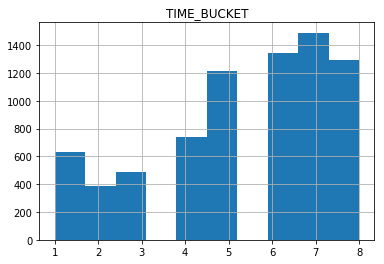

In [12]:
data_train[data_train['IS_FIRE'] == True].hist(column='TIME_BUCKET')

False    76573
True      7587
Name: IS_FIRE, dtype: int64

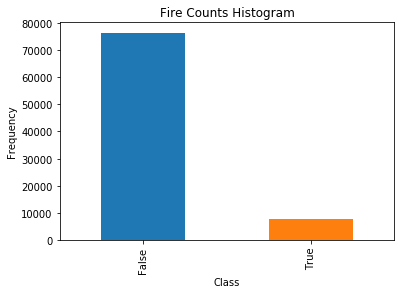

In [13]:
y_train = data_train['IS_FIRE']

pd.value_counts(y_train).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
y_train.value_counts()

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

labelencoder = LabelEncoder()
arrond_df = pd.DataFrame(labelencoder.fit_transform(data_train['NOM_ARROND']))

onehotencoder = OneHotEncoder()
arrond_df = pd.DataFrame(onehotencoder.fit_transform(arrond_df).toarray())
arrond_df.shape

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(84160, 35)

In [15]:
X_train = pd.concat([arrond_df, data_train[['Month','Day','TIME_BUCKET']]], axis=1)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,Month,Day,TIME_BUCKET
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,3
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,4


In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
X = X_sm
y = y_sm

True     76573
False    76573
dtype: int64

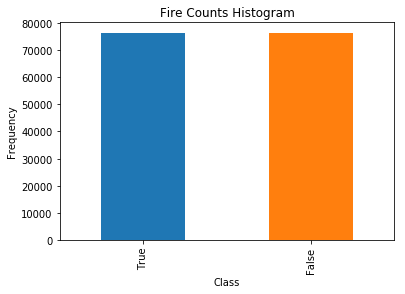

In [17]:
pd.value_counts(y_sm).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
pd.value_counts(y_sm)

In [18]:
y_sm.shape

(153146,)

In [19]:
X_sm.shape

(153146, 38)

In [20]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_sm, y_sm, test_size=0.2)

In [22]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

In [23]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [24]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [26]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

In [27]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

In [29]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [30]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
96.13,Random Forest
96.13,Decision Tree
89.76,KNN
65.90,Logistic Regression
65.69,Support Vector Machines
63.88,Stochastic Gradient Decent
63.85,Naive Bayes
58.03,Perceptron


In [31]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.90107738 0.89813908 0.89928175 0.8999347  0.90646425 0.89968985
 0.89340516 0.89796751 0.8988654  0.89510204]
Mean: 0.8989927116959944
Standard Deviation: 0.003313315705900018


In [ ]:
random_forest.feature_importances_

In [33]:
x_cols = pd.Series(range(0,38))
x_cols[35] = 'Month'
x_cols[36] = 'Day'
x_cols[37] = 'TIME_BUCKET'
print(x_cols.values)

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 'Month' 'Day' 'TIME_BUCKET']


In [34]:
importances = pd.DataFrame({'feature':x_cols.values,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Day,0.199
Month,0.173
TIME_BUCKET,0.151
32,0.040
15,0.036
5,0.033
22,0.030
0,0.028
24,0.027


In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.bestparams

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

In [ ]:
fire_interventions_pivot = fire_interventions.pivot_table(values='INCIDENT_NBR', index='NOM_ARROND', columns='INCIDENT_TYPE_DESC', aggfunc=pd.Series.nunique, fill_value = 0)
fire_interventions_pivot.shape

In [ ]:
fire_interventions_pivot.head(10)

In [ ]:
incident_type_df = pd.DataFrame(fire_interventions_pivot.to_records())
incident_type_df.head()

In [ ]:
fire_dict = {
'NOM_ARROND': 'NOM_ARROND',
'10-22 avec feu':"Total_Fires",
'Feu de champ *':"Total_Fires",
'Ac.vic. feu train/m√©tro F7/DES':"Total_Fires",
'Acc. sans vict. av. feu - ext.':"Total_Fires",
'Acc. sans vict. av. feu-tunnel':"Total_Fires",
'Acc. s-vict. av. feu - pont':"Total_Fires",
'Acc. s-vict. av. feu - v.r.':"Total_Fires",
'Acc. s-vict. av. feu-b√¢timent':"Total_Fires",
'Acc. s-vict. feu - train/m√©tro':"Total_Fires",
'Acc. vict. feu - tunnel F7/MOU':"Total_Fires",
'Acc. vict. sfeu tunnel F7/MOU':"Total_Fires",
'Acc. victime feu - b√¢timent':"Total_Fires",
'Acc. victime feu - pont':"Total_Fires",
'Acc. victime feu - voie rapide':"Total_Fires",
'Acc. victime feu ext.':"Total_Fires",
'Acc. victime sfeu - b√¢timent':"Total_Fires",
'Acc. victime sfeu - pont':"Total_Fires",
'Acc. victime sfeu - voie rap.':"Total_Fires",
'D√©chets en feu':"Total_Fires",
'Feu / 2e Alerte':"Total_Fires",
'Feu / 3e Alerte':"Total_Fires",
'Feu / 4e Alerte':"Total_Fires",
'Feu / 5e Alerte':"Total_Fires",
'Feu / Agravation possible':"Total_Fires",
'Feu d\'auto (voie rapide)':"Total_Fires",
'Feu de b√¢timent':"Total_Fires",
'Feu de chemin√©e *':"Total_Fires",
'Feu de cuisson':"Total_Fires",
'Feu de nature √©lectrique':"Total_Fires",
'Feu de navire/b√¢teau':"Total_Fires",
'Feu de v√©hicule ext√©rieur':"Total_Fires",
'Feu de v√©hicule int√©rieur':"Total_Fires",
'Feu de v√©hicule sur pont':"Total_Fires",
'feu de v√©hicule tunnel F7/MOU':"Total_Fires",
'Feu v√©h. convoi (train/m√©tro)':"Total_Fires",
'M√©tro b√¢timent /10-22 avec feu':"Total_Fires",
'M√©tro b√¢timent /10-22 sans feu':"Total_Fires",
'Senteur de feu √† l\'ext√©rieur]':"Total_Fires"}

fire_interventions_total = incident_type_df.groupby(fire_dict, axis = 1).sum()
fire_interventions_total.head(20)

In [ ]:
construction_year_df = pd.read_csv('data/uniteevaluationfonciere.csv')
construction_year_df = construction_year_df[['CIVIQUE_DEBUT','NOM_RUE','NOMBRE_LOGEMENT','ANNEE_CONSTRUCTION','NO_ARROND_ILE_CUM']]
construction_year_df.head()

In [ ]:
borough_map = {
'REM05': 'Outremont',
'REM09': 'Anjou',
'REM12': 'Verdun',
'REM14': 'Saint-Léonard',
'REM15': 'Saint-Laurent',
'REM16': 'Montréal-Nord',
'REM17': 'Lasalle',
'REM19': 'Ville-Marie',
'REM20': 'Sud-Ouest',
'REM21': 'Plateau Mont-Royal',
'REM22': 'Mercier / Hochelaga-Maisonneuve',
'REM23': 'Ahuntsic / Cartierville',
'REM24': 'Rosemont / Petite-Patrie',
'REM25': 'Villeray / St-Michel / Parc Extension',
'REM27': 'Lachine',
'REM31': 'Pierrefonds / Roxboro',
'REM32': 'L\'Ile-Bizard / Ste-Geneviève',
'REM33': 'Rivière-des-Prairies / Pointe-aux-Trembles',
'REM34': 'Côte-des-Neiges / Notre-Dame-de-Grâce'
}

construction_year_df["NOM_ARROND"] = construction_year_df["NO_ARROND_ILE_CUM"].map(borough_map)
construction_year_df.head(30)

In [ ]:
construction_year_df[['Street', 'Trigram']] = construction_year_df['NOM_RUE'].str.split('(',expand=True)
construction_year_df.drop('Street', axis=1, inplace=True)
construction_year_df['Trigram'] = construction_year_df['Trigram'].str.rstrip(')')
construction_year_df.head()

In [ ]:
construction_year_df_99 = construction_year_df[construction_year_df['NO_ARROND_ILE_CUM'] == 'REM99']
construction_year_df = construction_year_df[construction_year_df['NO_ARROND_ILE_CUM'] != 'REM99']

other_borough_map = {
    'PCL': 'Pointe-Claire', 
    'HMS': 'Hampstead',
    'SNV': 'Senneville',
    'DVL': 'Dorval', 
    'MTE': 'Montréal-Est',
    'MTR': 'Mont-Royal', 
    'CSL': 'Côte St-Luc', 
    'MTL+WMT': 'Westmount', 
    'BCF': 'Beaconsfield', 
    'KRK': 'Kirkland',
    'DDO': 'Dollard-des-Ormeaux',
    'CSL+MTL': 'Côte St-Luc',  
    'MTO': 'Montréal-Ouest', 
    'WMT': 'Westmount', 
    'DDO+PFD': 'Dollard-des-Ormeaux',
    'BDU': 'Baie d\'Urfé', 
    'MTL+MTR':'Mont-Royal',
    'SAB': 'Ste-Anne-de-Bellevue'
}

construction_year_df_99["NOM_ARROND"] = construction_year_df_99.Trigram.map(other_borough_map)
construction_year_df = construction_year_df.append(construction_year_df_99)
construction_year_df.drop(['Trigram', 'NO_ARROND_ILE_CUM', 'CIVIQUE_DEBUT', 'NOM_RUE', 'NOMBRE_LOGEMENT'], axis=1, inplace=True)
construction_year_df.head()

In [ ]:
construction_year_group = construction_year_df.groupby("NOM_ARROND", as_index=True)['ANNEE_CONSTRUCTION'].mean()
construction_year_group.head()

In [ ]:
construction_year_group_df = pd.DataFrame(construction_year_group)
construction_year_group_df.head()

In [ ]:
fire_full_df = pd.merge(fire_interventions_total, construction_year_group_df, on = 'NOM_ARROND', how='left')
fire_full_df.head(35)

In [ ]:
socio_demo_df = pd.read_csv('data/socio2.csv')
socio_demo_df.head(10)

In [ ]:
fire_full_df = pd.merge(fire_full_df, socio_demo_df, on = 'NOM_ARROND')
fire_full_df.head(35)

In [ ]:
fire_full_df.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fire_full_no_boroughs_df = fire_full_df.drop('NOM_ARROND', axis=1)
fire_full_no_boroughs_df = pd.DataFrame(scaler.fit_transform(fire_full_no_boroughs_df), columns = fire_full_no_boroughs_df.columns)
fire_full_no_boroughs_df.head(35)

In [ ]:
y_train = fire_full_no_boroughs_df['Total_Fires']
X_train = fire_full_no_boroughs_df.drop('Total_Fires', axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
model = regressor.fit(X_train, y_train)

In [ ]:
regressor.score(X_train, y_train)

In [ ]:
regressor.coef_

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, X_train.columns, columns=['Coefficient'])
coeff_df

In [ ]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]
 
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clust_data)
    prediction=model.predict(clust_data)
    meanDistortions.append(sum(np.min(cdist(clust_data, model.cluster_centers_, 'euclidean'), axis=1)) / clust_data.shape[0])
 
#plt.cla()
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [ ]:
final_model=KMeans(8)
final_model.fit(clust_data)
prediction=final_model.predict(clust_data)
 
#Join predicted clusters back to raw data
incident_type_df["GROUP"] = prediction
print("Groups Assigned : \n")
incident_type_df[["GROUP","NOM_ARROND"]].sort_values('GROUP')

In [ ]:
gen = (x for x in incident_type_df if x not in "NOM_ARROND")

for column in gen:
    boxplot_field = column
    plt.figure()
    plt.suptitle(boxplot_field)
    plt.boxplot([incident_type_df[boxplot_field][incident_type_df.GROUP==0],
            incident_type_df[boxplot_field][incident_type_df.GROUP==1],
            incident_type_df[boxplot_field][incident_type_df.GROUP==2],
            incident_type_df[boxplot_field][incident_type_df.GROUP==3],
            incident_type_df[boxplot_field][incident_type_df.GROUP==4],
            incident_type_df[boxplot_field][incident_type_df.GROUP==5],
            incident_type_df[boxplot_field][incident_type_df.GROUP==6],
            incident_type_df[boxplot_field][incident_type_df.GROUP==7]],
            labels=('G1','G2','G3','G4','G5','G6','G7','G8'));

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

labelencoder = LabelEncoder()
arrond_df = pd.DataFrame(labelencoder.fit_transform(interventions_df['NOM_ARROND']))


onehotencoder = OneHotEncoder()
arrond_df = pd.DataFrame(onehotencoder.fit_transform(arrond_df).toarray())


In [ ]:
arrond_df.head()

In [ ]:
kmeans = KMeans(n_clusters = 20, n_init = 5, n_jobs = -1)
kmeans.fit(arrond_df)

In [ ]:
interventions_df['cluster'] = kmeans.labels_

In [ ]:
type(unique_incident_types)

In [ ]:
interventions_df = interventions_df[interventions_df['INCIDENT_TYPE_DESC'].isin(unique_incident_types)]

In [ ]:

clusters = interventions_df.groupby(['cluster', 'INCIDENT_TYPE_DESC']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'INCIDENT_TYPE_DESC'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('INCIDENT_TYPE_DESC', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [ ]:
interventions_df.head(40)